Total Generation from Wind Turbines (with storage):
Wind Turbine 0: 3169.28 MW
Wind Turbine 1: 3023.49 MW
Wind Turbine 2: 1932.68 MW
Wind Turbine 3: 2849.33 MW
Wind Turbine 4: 3095.98 MW
Wind Turbine 5: 2401.37 MW

Total Generation from Conventional Generators (with storage):
Generator 0: 0.00 MW
Generator 1: 0.00 MW
Generator 2: 0.00 MW
Generator 3: 0.00 MW
Generator 4: 0.00 MW
Generator 5: 2769.23 MW
Generator 6: 2329.14 MW
Generator 7: 9192.79 MW
Generator 8: 9600.00 MW
Generator 9: 7200.00 MW
Generator 10: 4156.65 MW
Generator 11: 1081.79 MW
Total Profit from Wind Turbines (with storage):
Wind Turbine 0: $32004.28
Wind Turbine 1: $30017.74
Wind Turbine 2: $19152.83
Wind Turbine 3: $28386.39
Wind Turbine 4: $30661.50
Wind Turbine 5: $23795.64

Total Profit from Conventional Generators (with storage):
Generator 0: $0.00
Generator 1: $0.00
Generator 2: $0.00
Generator 3: $0.00
Generator 4: $0.00
Generator 5: $688.20
Generator 6: $688.20
Generator 7: $37582.05
Generator 8: $42862.05
Ge

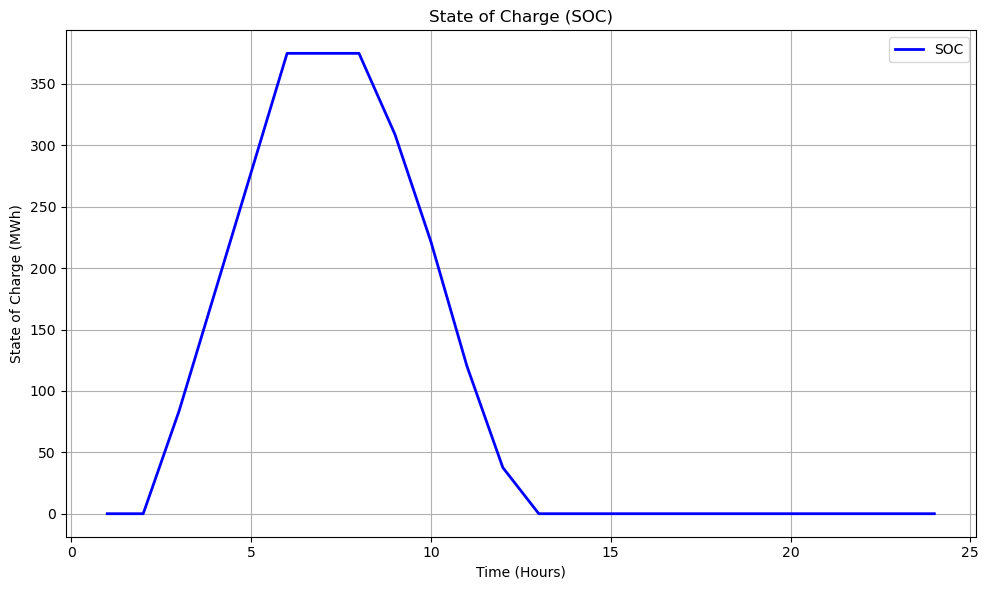

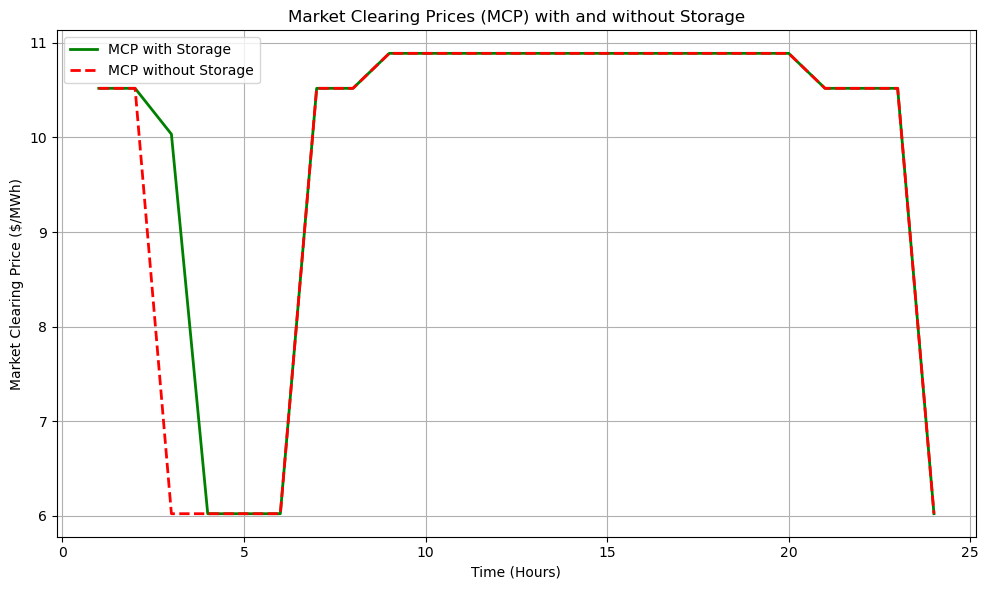

In [1]:
# Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
from pyomo.environ import *
import pandas as pd
from data import L_D_Hours, Wind_Hours, PC_DA, P_max, Load_Demand, Cost_Generation, Wind_Farm_Power, Wind, T, N  # Import data from data.py

# Define number of demand nodes, wind farms, and generators 
Dem = len(L_D_Hours)  # Number of demand nodes
Wind = len(Wind_Hours)  # Number of wind farms
Gen = len(P_max)  # Number of generators

# Load bid data from a CSV 
file_path = "day_ahead_bids.csv"
df = pd.read_csv(file_path)

# Ensure correct column names
df.columns = ["Hour", "Bid Price", "Bid Amount"]

# Convert bid data into a dictionary grouped by hour
bid_data = {}
for hour, group in df.groupby("Hour"):
    bid_data[hour] = group[["Bid Price", "Bid Amount"]].to_dict(orient="records")

# Create a bid price map for each demand node (1 to Dem) for each hour
bid_prices = {}  
for hour in range(1, T + 1):
    # Get the sorted bids by price for the current hour
    sorted_bids = sorted(bid_data.get(hour, []), key=lambda x: x["Bid Price"])
    
    # Allocate bid prices to demand nodes based on sorted bids
    total_bid_amount = 0
    bid_prices[hour] = []
    
    for bid in sorted_bids:
        bid_price = bid["Bid Price"]
        bid_amount = bid["Bid Amount"]
        
        # Allocate the bid price to demand nodes 
        for _ in range(int(bid_amount)): 
            bid_prices[hour].append(bid_price)
    
    if len(bid_prices[hour]) < Dem:
        # Fill the remaining demand nodes with the highest available price
        highest_price = sorted_bids[-1]["Bid Price"]
        bid_prices[hour].extend([highest_price] * (Dem - len(bid_prices[hour])))

# Model with storage
model = ConcreteModel()
model.dual = Suffix(direction=Suffix.IMPORT)

# Time periods (1 to 24)
T = 24

# Decision Variables for each time period
model.P_g = Var(range(Gen), range(1, T+1), domain=NonNegativeReals)  # Production of conventional generators
model.P_w = Var(range(Wind), range(1, T+1), domain=NonNegativeReals)  # Production of wind farms
model.P_d = Var(range(Dem), range(1, T+1), domain=NonNegativeReals)  # Demand
model.P_ch = Var(range(1, T+1), domain=NonNegativeReals)  # Charging of storage unit
model.P_dis = Var(range(1, T+1), domain=NonNegativeReals)  # Discharging of storage unit
model.e_t = Var(range(1, T+1), domain=NonNegativeReals)  # Energy stored at each hour

# Parameters for storage operation
P_ch_max = 100  # Maximum charging capacity of the storage unit (MW)
P_dis_max = 100  # Maximum discharging capacity of the storage unit (MW)
E_max = 750  # Energy storage capacity (MWh)
eta_ch = 0.97  # Charging efficiency
eta_dis = 0.95  # Discharging efficiency

# Objective function: social welfare maximization
def objective_rule(model):
    total_welfare = 0
    for t in range(1, T+1):
        total_welfare += sum(bid_prices[t][dem] * model.P_d[dem, t] for dem in range(Dem)) - \
                          sum(PC_DA[gen] * model.P_g[gen, t] for gen in range(Gen)) - \
                          sum(0 * model.P_w[wind, t] for wind in range(Wind))  # No cost for wind
    return total_welfare

model.obj = Objective(rule=objective_rule, sense=maximize)

# Constraints

# Capacity constraints for conventional generation
def conventional_generation_rule(model, gen, t):
    return model.P_g[gen, t] <= P_max[gen]  # Generator capacity constraint

model.conventional_generation = Constraint(range(Gen), range(1, T+1), rule=conventional_generation_rule)

# Capacity constraints for wind generation
def wind_generation_rule(model, wind, t):
    return model.P_w[wind, t] <= Wind_Hours[wind, t-1]  # Wind generation based on wind profile

model.wind_generation = Constraint(range(Wind), range(1, T+1), rule=wind_generation_rule)

# Demand constraint (Demand should be met at each hour)
def demand_rule(model, dem, t):
    return model.P_d[dem, t] <= L_D_Hours[dem, t-1]  # Use the demand profile for each hour

model.demand = Constraint(range(Dem), range(1, T+1), rule=demand_rule)

# Balance constraint (Total generation = total demand + storage operations)
def balance_rule(model, t):
    return sum(model.P_d[dem, t] for dem in range(Dem)) == \
           sum(model.P_g[gen, t] for gen in range(Gen)) + \
           sum(model.P_w[wind, t] for wind in range(Wind)) + \
           model.P_dis[t] - model.P_ch[t]  # Storage discharges and charges

model.balance = Constraint(range(1, T+1), rule=balance_rule)

# Storage capacity constraints
def storage_capacity_rule(model, t):
    return model.e_t[t] <= E_max  # Energy in storage should not exceed capacity

model.storage_capacity = Constraint(range(1, T+1), rule=storage_capacity_rule)

# Energy storage dynamics (charging/discharging efficiency)
def storage_dynamics_rule(model, t):
    if t == 1:
        return model.e_t[t] == 0 + model.P_ch[t] * eta_ch - model.P_dis[t] / eta_dis  # Initial condition
    else:
        return model.e_t[t] == model.e_t[t-1] + model.P_ch[t] * eta_ch - model.P_dis[t] / eta_dis

model.storage_dynamics = Constraint(range(1, T+1), rule=storage_dynamics_rule)

# Charging and discharging limits
def charging_limit_rule(model, t):
    return model.P_ch[t] <= P_ch_max

model.charging_limit = Constraint(range(1, T+1), rule=charging_limit_rule)

def discharging_limit_rule(model, t):
    return model.P_dis[t] <= P_dis_max

model.discharging_limit = Constraint(range(1, T+1), rule=discharging_limit_rule)

# Solve the model using GLPK
solver = SolverFactory('glpk')
solver.solve(model)

# Battery SOC (State of Charge) for the model with storage
SOC_with_storage = np.array([model.e_t[t].value for t in range(1, T+1)])

# Market Clearing Prices with storage
MCP_with_storage = np.array([model.dual[model.balance[t]] for t in range(1, T+1)])

# Social welfare with storage (objective value)
social_welfare_with_storage = model.obj()

# Print the total generation from each wind turbine
print("Total Generation from Wind Turbines (with storage):")
for wind in range(Wind):
    total_generation_wind = sum(model.P_w[wind, t].value for t in range(1, T+1))
    print(f"Wind Turbine {wind}: {total_generation_wind:.2f} MW")

# Print the total generation from each conventional generator
print("\nTotal Generation from Conventional Generators (with storage):")
for gen in range(Gen):
    total_generation_gen = sum(model.P_g[gen, t].value for t in range(1, T+1))
    print(f"Generator {gen}: {total_generation_gen:.2f} MW")

    
# Print the total profit from each wind turbine
print("Total Profit from Wind Turbines (with storage):")
for wind in range(Wind):
    total_profit_wind = 0
    for t in range(1, T+1):
        total_profit_wind += MCP_with_storage[t-1] * model.P_w[wind, t].value  
    print(f"Wind Turbine {wind}: ${total_profit_wind:.2f}")

# Print the total profit from each conventional generator
print("\nTotal Profit from Conventional Generators (with storage):")
for gen in range(Gen):
    total_profit_gen = 0
    for t in range(1, T+1):
        total_profit_gen += MCP_with_storage[t-1] * model.P_g[gen, t].value  
        total_profit_gen -= PC_DA[gen] * model.P_g[gen, t].value  # Subtracting the generation cost
    print(f"Generator {gen}: ${total_profit_gen:.2f}")

# Calculate battery profit
battery_revenue = sum(MCP_with_storage[t-1] * model.P_dis[t].value for t in range(1, T+1))
battery_cost = sum(MCP_with_storage[t-1] * model.P_ch[t].value for t in range(1, T+1))
battery_profit = battery_revenue - battery_cost

# Print battery profit
print(f"\n Battery Profit: ${battery_profit:.2f}")

######### NO STORAGE #########

# Model without Storage
model_no_storage = ConcreteModel()
model_no_storage.dual = Suffix(direction=Suffix.IMPORT)

# Decision Variables for each time period (without storage)
model_no_storage.P_g = Var(range(Gen), range(1, T+1), domain=NonNegativeReals)  # Production of conventional generators
model_no_storage.P_w = Var(range(Wind), range(1, T+1), domain=NonNegativeReals)  # Production of wind farms
model_no_storage.P_d = Var(range(Dem), range(1, T+1), domain=NonNegativeReals)  # Demand

# Objective function: social welfare maximization 
def objective_rule_no_storage(model):
    total_welfare = 0
    for t in range(1, T+1):
        total_welfare += sum(bid_prices[t][dem] * model.P_d[dem, t] for dem in range(Dem)) - \
                          sum(PC_DA[gen] * model.P_g[gen, t] for gen in range(Gen)) - \
                          sum(0 * model.P_w[wind, t] for wind in range(Wind))  # No cost for wind
    return total_welfare

model_no_storage.obj = Objective(rule=objective_rule_no_storage, sense=maximize)

# Constraints
def conventional_generation_rule(model, gen, t):
    return model.P_g[gen, t] <= P_max[gen]  # Generator capacity constraint

model_no_storage.conventional_generation = Constraint(range(Gen), range(1, T+1), rule=conventional_generation_rule)

# Capacity constraints for wind generation
def wind_generation_rule(model, wind, t):
    return model.P_w[wind, t] <= Wind_Hours[wind, t-1]  # Wind generation based on wind profile

model_no_storage.wind_generation = Constraint(range(Wind), range(1, T+1), rule=wind_generation_rule)

# Demand constraint (Demand should be met at each hour)
def demand_rule(model, dem, t):
    return model.P_d[dem, t] <= L_D_Hours[dem, t-1]  # Use the demand profile for each hour

model_no_storage.demand = Constraint(range(Dem), range(1, T+1), rule=demand_rule)

# Balance constraint (Total generation = total demand)
def balance_rule(model, t):
    return sum(model.P_d[dem, t] for dem in range(Dem)) == \
           sum(model.P_g[gen, t] for gen in range(Gen)) + \
           sum(model.P_w[wind, t] for wind in range(Wind))  # No storage

model_no_storage.balance = Constraint(range(1, T+1), rule=balance_rule)

# Solve the model without storage
solver.solve(model_no_storage)

# Market Clearing Prices without storage
MCP_without_storage = np.array([model_no_storage.dual[model_no_storage.balance[t]] for t in range(1, T+1)])

# Social welfare without storage
social_welfare_without_storage = model_no_storage.obj()

# Results display

# Print the total generation from each wind turbine (no storage)
print("Total Generation from Wind Turbines (no storage):")
for wind in range(Wind):
    total_generation_wind = sum(model_no_storage.P_w[wind, t].value for t in range(1, T+1))
    print(f"Wind Turbine {wind}: {total_generation_wind:.2f} MW")

# Print the total generation from each conventional generator (no storage)
print("\nTotal Generation from Conventional Generators (no storage):")
for gen in range(Gen):
    total_generation_gen = sum(model_no_storage.P_g[gen, t].value for t in range(1, T+1))
    print(f"Generator {gen}: {total_generation_gen:.2f} MW")

# Print the total profit from each wind turbine (no storage)
print("Total Profit from Wind Turbines (no storage):")
for wind in range(Wind):
    total_profit_wind = 0
    for t in range(1, T+1):
        total_profit_wind += MCP_without_storage[t-1] * model_no_storage.P_w[wind, t].value  
    print(f"Wind Turbine {wind}: ${total_profit_wind:.2f}")

# Print the total profit from each conventional generator (no storage)
print("\nTotal Profit from Conventional Generators (no storage):")
for gen in range(Gen):
    total_profit_gen = 0
    for t in range(1, T+1):
        total_profit_gen += MCP_without_storage[t-1] * model_no_storage.P_g[gen, t].value  
        total_profit_gen -= PC_DA[gen] * model_no_storage.P_g[gen, t].value  # Subtracting the generation cost
    print(f"Generator {gen}: ${total_profit_gen:.2f}")




print("Battery SOC with storage (for each hour):", SOC_with_storage)
print("Market Clearing Prices with storage (for each hour):", MCP_with_storage)
print("Market Clearing Prices without storage (for each hour):", MCP_without_storage)
print("Social Welfare with storage:", social_welfare_with_storage)
print("Social Welfare without storage:", social_welfare_without_storage)


import matplotlib.pyplot as plt

# Plot 1: State of Charge (SOC) 
plt.figure(figsize=(10, 6))
plt.plot(range(1, T+1), SOC_with_storage, label="SOC", color='b', linewidth=2)
plt.title("State of Charge (SOC)")
plt.xlabel("Time (Hours)")
plt.ylabel("State of Charge (MWh)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Market Clearing Prices (MCP) with and without storage
plt.figure(figsize=(10, 6))
plt.plot(range(1, T+1), MCP_with_storage, label="MCP with Storage", color='g', linestyle='-', linewidth=2)
plt.plot(range(1, T+1), MCP_without_storage, label="MCP without Storage", color='r', linestyle='--', linewidth=2)
plt.title("Market Clearing Prices (MCP) with and without Storage")
plt.xlabel("Time (Hours)")
plt.ylabel("Market Clearing Price ($/MWh)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()